## Прогнозирование уровня средней заработной платы в России

Придерживайтесь стандартного алгоритма построения прогноза:

- Визуальный анализ ряда

- Стабилизация дисперсии (при необходимости)

- Выбор порядка дифференцирования

- Выбор начальных приближений для p,q,P,Q

- Обучение и сравнение моделей-кандидатов, выбор победителя

- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.

- Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.


Импорт стандартных пакетов для анализа данных

In [22]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
# import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Miniconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


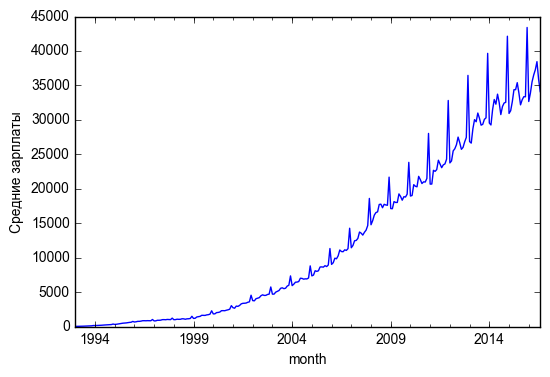

In [23]:
df = pd.read_csv('WAG_C_M.csv',';', parse_dates=['month'], dayfirst=True)
df.rename(columns={'WAG_C_M': 'salary'}, inplace=True)
df.reset_index(inplace=True)
df['month'] = pd.to_datetime(df['month'])
df = df.set_index('month')
df.salary.plot()
plt.ylabel('Средние зарплаты')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


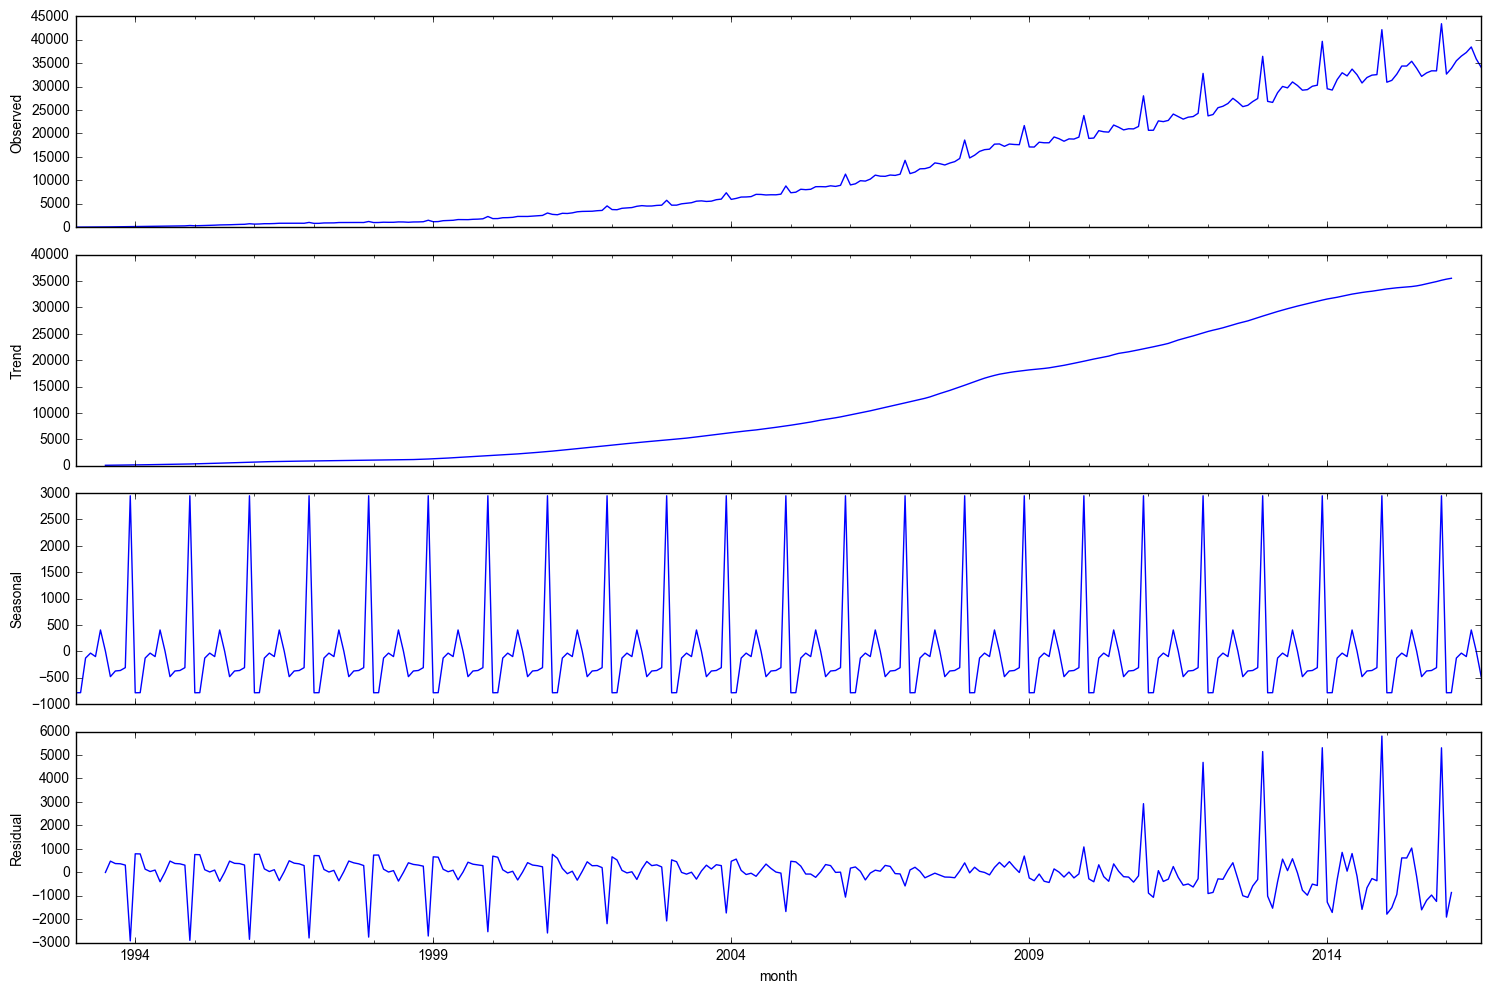

In [24]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary)[1])

### - Стабилизация дисперсии (при необходимости)

Оптимальный параметр преобразования Бокса-кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


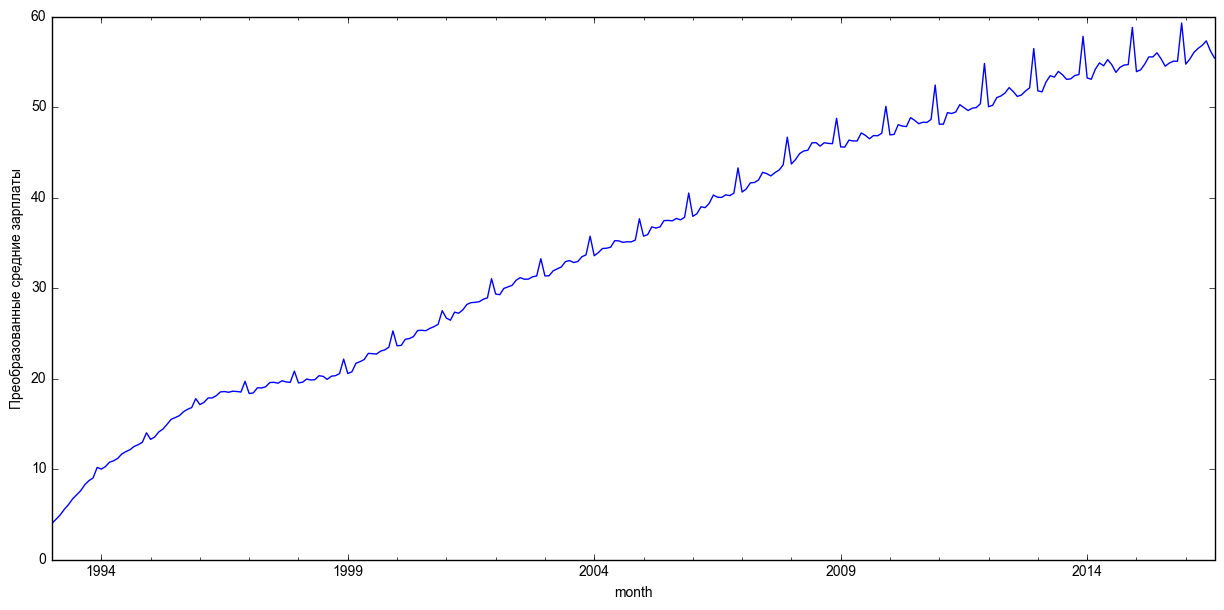

In [25]:
df['salary_box'], lmbda = stats.boxcox(df.salary)
plt.figure(figsize(15,7))
df.salary_box.plot()
plt.ylabel(u'Преобразованные средние зарплаты')
print("Оптимальный параметр преобразования Бокса-кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box)[1])

### - Выбор порядка дифференцирования

Критерий Дики-Фуллера подтверждает гипотезу нестационарности, и визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


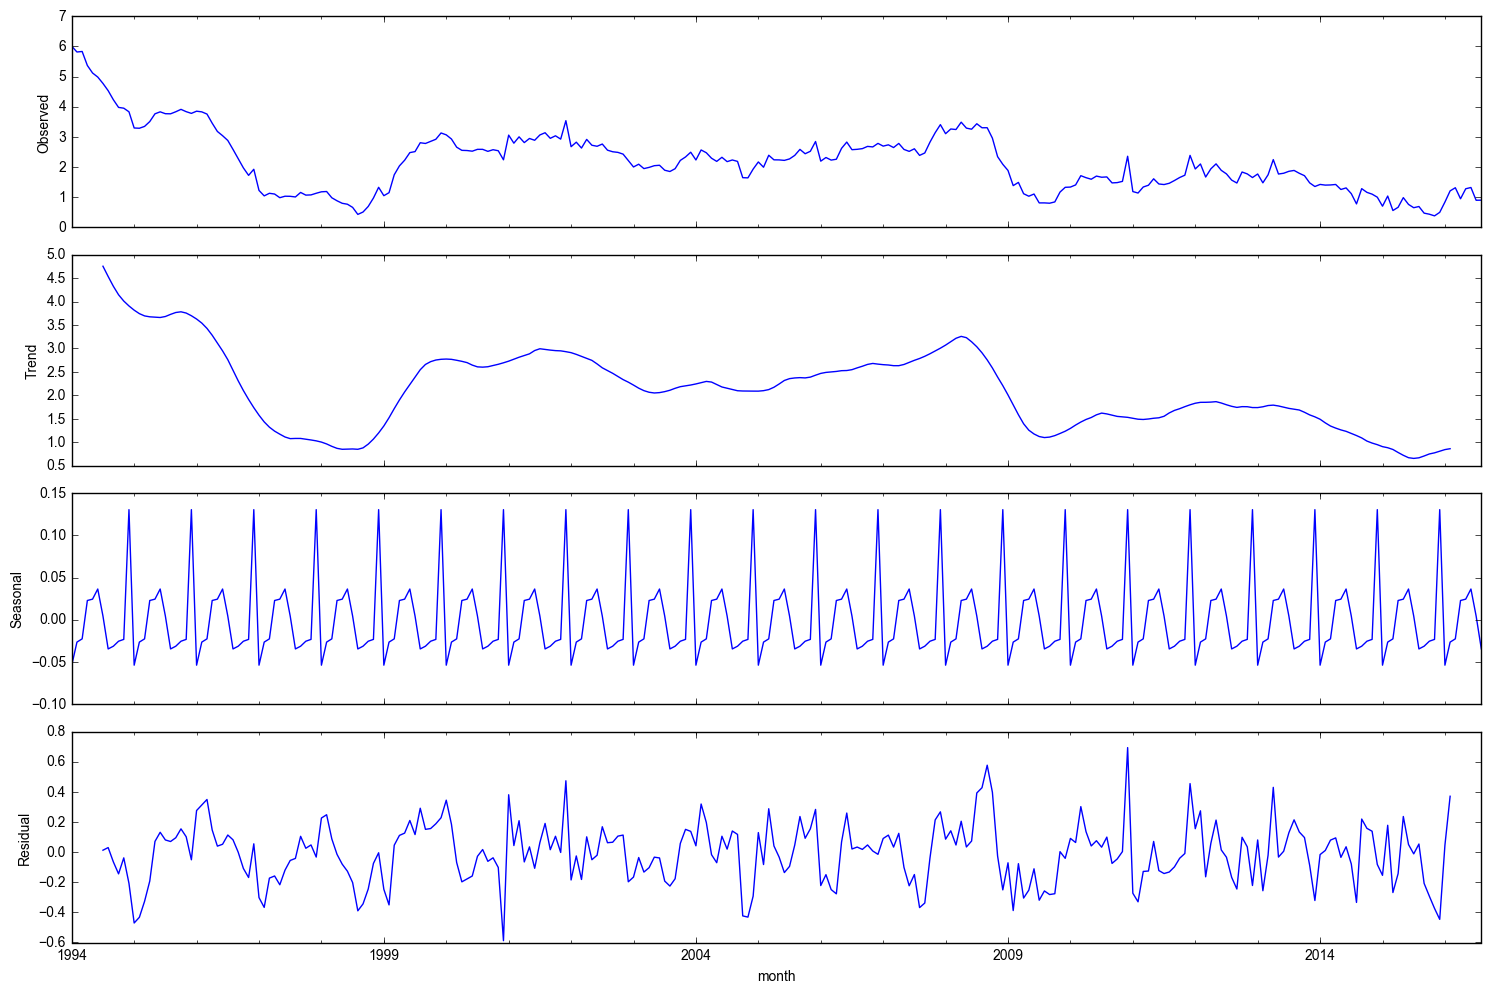

In [26]:
df['salary_box_diff'] = df.salary_box - df.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


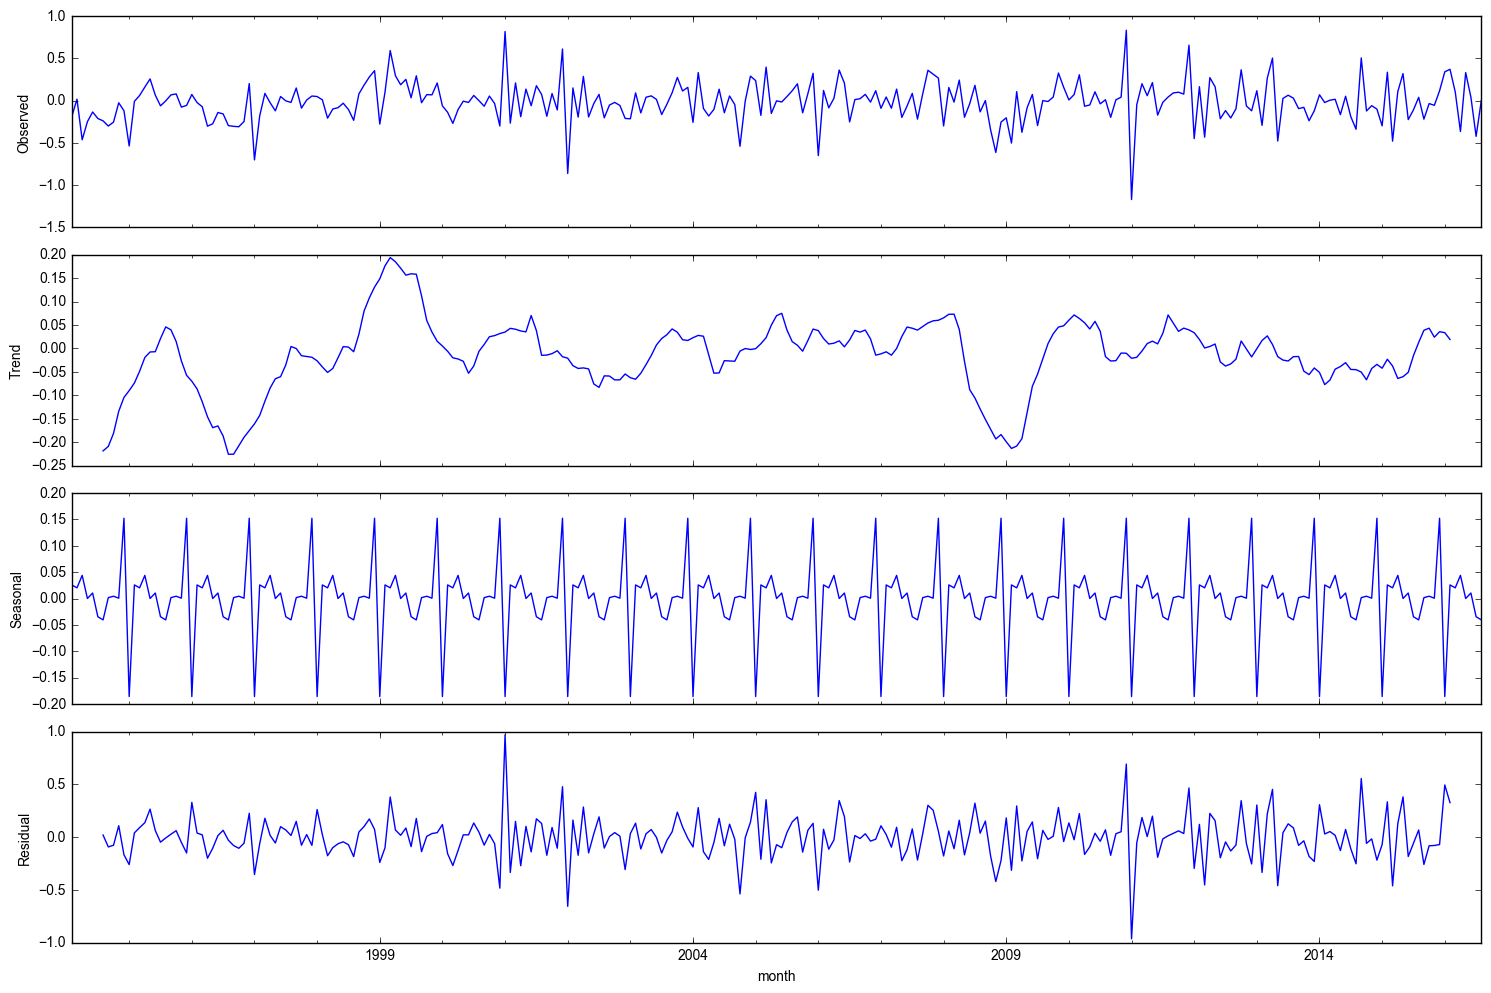

In [27]:
df['salary_box_diff2'] = df.salary_box_diff - df.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

### - Выбор начальных приближений для p,q,P,Q

Посмотрим на ACF и PACF полученного ряда:

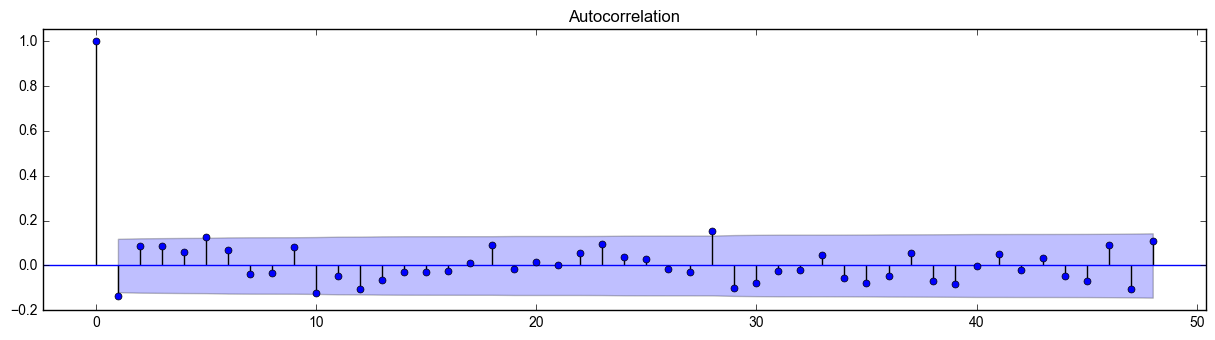

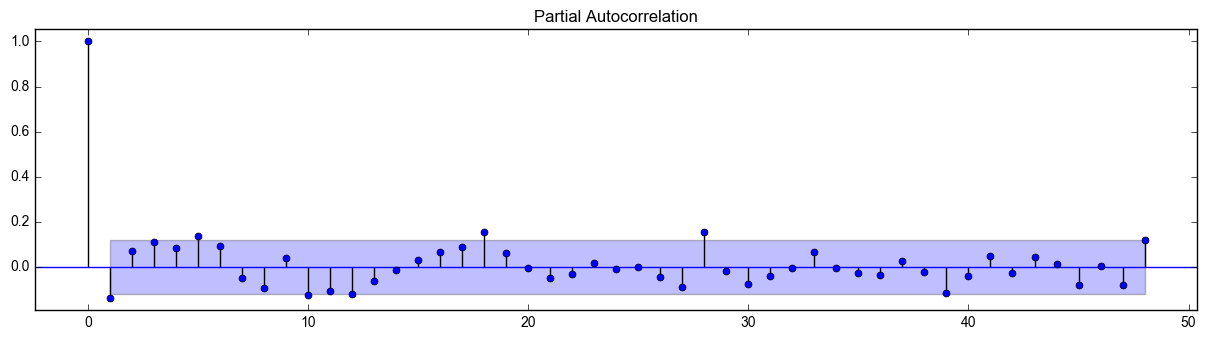

In [28]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Значение Q равно последнему сезонному лагу со значимой автокорреляцией, значение q -- последнему несезонному лагу
Q = 0, q = 5
Значение P равно последний сезонный лаг со значимой частичной автокорреляцией, p - аналогично несезонный
P = 0, p = 28

### - Обучение и сравнение моделей-кандидатов, выбор победителя

In [29]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [30]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [31]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print( 'wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
Wall time: 22.2 s


In [32]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
29  (3, 1, 1, 0) -4.995859
28  (3, 1, 0, 1) -4.342767
30  (3, 1, 1, 1) -4.312788
37  (4, 1, 1, 0) -3.975974
36  (4, 1, 0, 1) -3.362304


In [33]:
print (best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                   8.498
Date:                            Fri, 07 Oct 2016   AIC                             -4.996
Time:                                    07:57:33   BIC                             16.898
Sample:                                01-01-1993   HQIC                             3.782
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4854      0.210      2.313      0.021       0.074       0.897
ar.L2          0.1630      0.075   

### - Анализ остатков построенной модели, 
при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.

Критерий Стьюдента: p=0.281916
Критерий Дики-Фуллера: p=0.000000


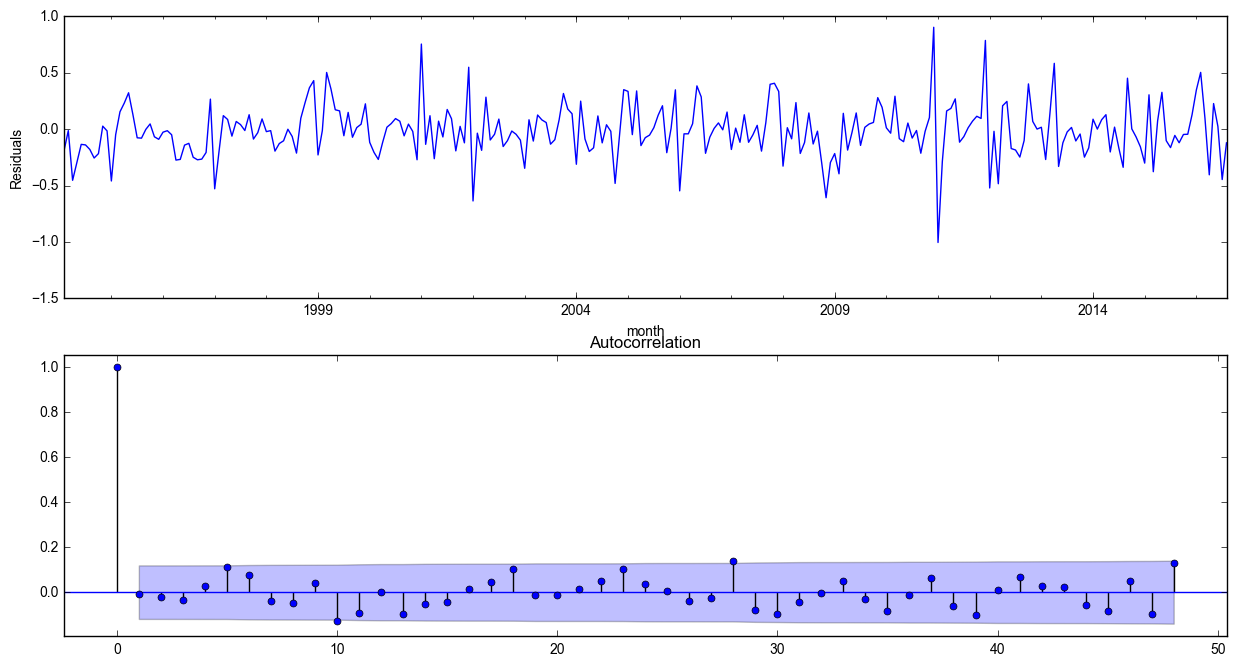

In [34]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print ("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

##### Как мы видим, модель описывает данные просто великолепно

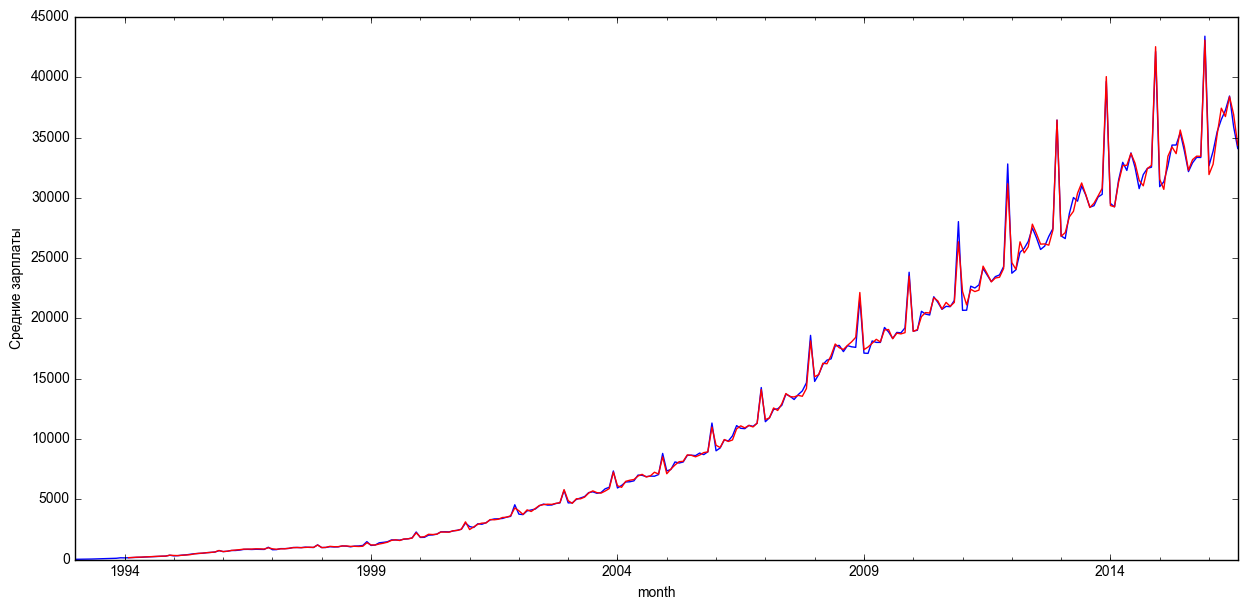

In [35]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.salary.plot()
df.model[13:].plot(color='r')
plt.ylabel('Средние зарплаты')
pylab.show()

### Прогнозирование на основе модели

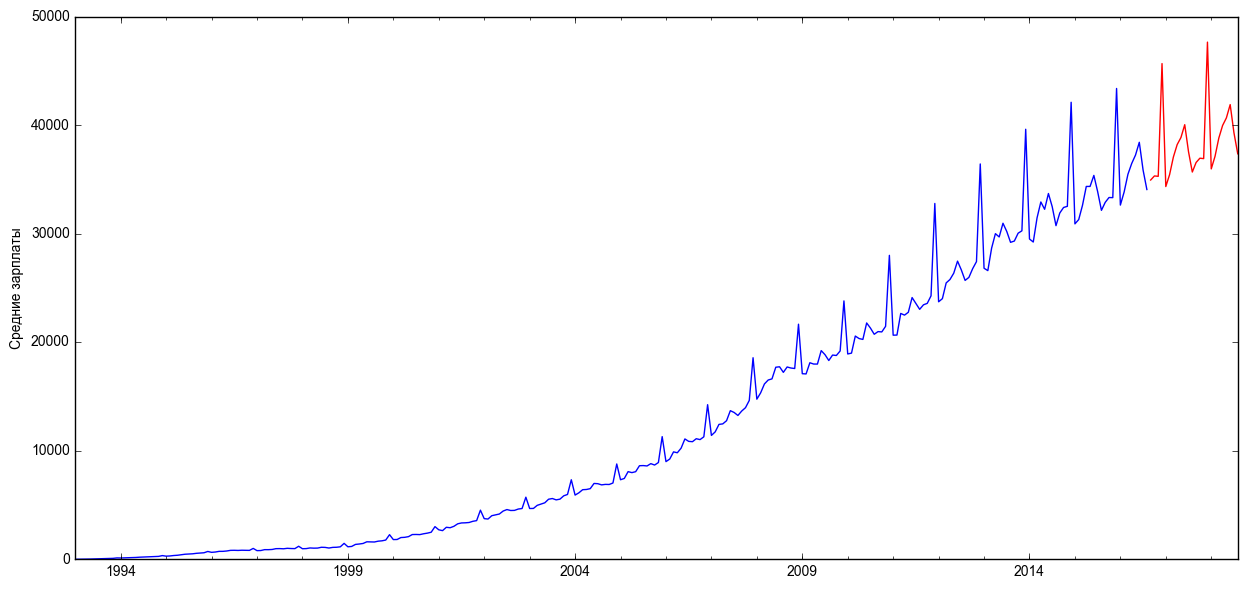

In [40]:
df2 = df[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=309), lmbda)

plt.figure(figsize(15,7))
df2.salary.plot()
df2.forecast.plot(color='r')
plt.ylabel('Средние зарплаты')
pylab.show()